In [1]:
import numpy as np
import heapq
import random
import math
import pprint
import matplotlib.pyplot as plt
import time
Distance = [[0,1064,673,1401,277],
            [1064,0,958,1934,377],
            [673,957,0,1001,399],
            [1401,1934,1001,0,387],
            [277,377,399,387,0]]
Distance_cpy = [[0,1064,673,1401,277],
            [1064,0,958,1934,377],
            [673,957,0,1001,399],
            [1401,1934,1001,0,387],
            [277,377,399,387,0]]
W_ = {1:{1:'A',2:'E',3:'D',4:'C',5:'A'},
        2:{1:'B',2:'E',3:'A',4:'C',5:'D'},
        3:{1:'B',2:'A',3:'B',4:'C',5:'E'},
        4:{1:'D',2:'A',3:'D',4:'B',5:'D'},
        5:{1:'B',2:'E',3:'C',4:'B',5:'D'}}
Starting_Point = ['A','B','C','D','E']
fac_dict = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4}
rev_fac_dict = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E'}
mp ={}

In [2]:
def extract_distance():
    for i in Starting_Point:
        dd = 20000
        for j in Starting_Point:
            if get_gscore_dist(i,j)<dd and i != j:
                dd = get_gscore_dist(i,j)
                mp[i]=j
#     print(mp)
    for i in Starting_Point:
        for j in Starting_Point:
            if get_gscore_dist(i,j)>(get_gscore_dist(i,mp[i])+get_gscore_dist(mp[i],j)):
                Distance[fac_dict[i]][fac_dict[j]]=get_gscore_dist(i,mp[i])+get_gscore_dist(mp[i],j)
#     print(Distance)
def backup_distance():
    Distance = [[0,1064,673,1401,277],
                [1064,0,958,1934,377],
                [673,957,0,1001,399],
                [1401,1934,1001,0,387],
                [277,377,399,387,0]]

In [3]:
class node():
    def __init__(self, cur_factory,last_table, gscore=float('inf'),fscore=float('inf'), parent=''):
        self.gscore = gscore
        self.last_table = last_table
        self.cur_factory = cur_factory
        self.parent = parent
        self.fscore = fscore
    
    def __key(self):
        return (self.parent)
    
    def __eq__(self, other):
        return (np.array_equal(self.last_table,other.last_table) and self.gscore <= other.gscore)
    
    def __lt__(self, other):
        return self.fscore < other.fscore
    
    def __hash__(self):
        return hash(self.__key())

In [4]:
def h_min_dis(node,factory,W):
    table = node.last_table.copy()
    temp = node.cur_factory
    table2 = table.copy()
    table2 = table2.T
    fscore = 0
    for num, i in enumerate (table):
        if table2[num].sum() != 0:
            fscore=fscore+Distance[fac_dict[temp]][fac_dict[mp[temp]]]
            temp = mp[temp]
        for j in range(len(i)):
            if i[j] == 1:
                if W[num+1][j+1] == factory: i[j] = i[j] - 1
                break;
    return table,fscore                      
    
def h_min_step(node,factory,W):
    '''
    calculate the huristic of a certain step of node
    '''
    table = node.last_table.copy()
    table2 = table.copy()
    table2 = table2.T
    fscore = 0
    for num, i in enumerate (table):
        if num < (len(table2)):
            if table2[num].sum() != 0:fscore=fscore+1
        for j in range(len(i)):
            if i[j] == 1:
                if W[num+1][j+1] == factory: i[j] = i[j] - 1
                break;
    return table,fscore

def get_gscore_dist(city1,city2):
    return Distance[fac_dict[city1]][fac_dict[city2]]

def get_close(table):
    s = ''
    for i in table:
        j = i.sum()
        s = s+ str(int(j))
    return s

def get_step(a,b):
    return 1

def get_low_rank(open_set):
    min_huris = float('inf')
    for nodes in open_set:
        if (nodes.fscore)<min_huris:
            cur_node = nodes
            min_huris = cur_node.fscore  
    return cur_node

def goal_test(node):
    if node.last_table.sum() == 0: return True
    return False

In [12]:
def A_star(start,hu,get_func,N=5,W=W_):
    node_expanded=1
    hu_table = np.ones((5,N))
    initnode = node(start,hu_table,gscore=0,fscore=25.0)
    table,fscore = hu(initnode,start,W)
    start_node = node(start,table,gscore=0,fscore=fscore,parent=start)
    close_set = {}
    open_set = []
    heapq.heappush(open_set,start_node)
    cities = ['A','B','C','D','E']
    while len(open_set)!=0:
        cur_node = heapq.heappop(open_set) 
        if goal_test(cur_node): 
#             print('node expanded=',node_expanded)
            return cur_node.parent,node_expanded
        close_set[get_close(cur_node.last_table)]=cur_node.gscore
        for city in cities:
            if city == cur_node.cur_factory: continue
            table,fscore = hu(cur_node,city,W)
            cost = cur_node.gscore+get_func(cur_node.cur_factory,city)
            if get_close(table) in close_set:
                if close_set[get_close(table)] < cost:
                    continue
                close_set[get_close(table)] = cost
            new_node = node(city,table,gscore=cost,fscore=fscore+cost,parent=cur_node.parent+city)
            heapq.heappush(open_set,new_node)
            node_expanded = node_expanded + 1
    return

In [13]:
backup_distance()
for t in Starting_Point:
    lenn = 1000
    print('for starting =',t)
    retv,ex = A_star(t,h_min_step,get_step)
    dis = 0
#     for s in retv:
#         dis = dis + get_gscore_dist(t,s)
#         t = s
#     print(dis)
    print('temp=',retv)
    print('len=',len(retv))
    print()

for starting = A
temp= ABEDCADBCDE
len= 11

for starting = B
temp= BDAEDCBACDE
len= 11

for starting = C
temp= CBDAEDCBACED
len= 12

for starting = D
temp= DABEDCABCDE
len= 11

for starting = E
temp= EBDAEDCBACED
len= 12



In [14]:
extract_distance()
for t in Starting_Point:
    lenn = 1000
    print('for starting =',t)
    retv,ex = A_star(t,h_min_dis,get_gscore_dist)
    startttt = t
    dis = 0
    new_sequence = ''
    for s in retv:
        if get_gscore_dist(startttt,s) != Distance_cpy[fac_dict[startttt]][fac_dict[s]]:
            new_sequence = new_sequence + mp[s]
            new_sequence = new_sequence + s
        else:
            new_sequence = new_sequence + s
        dis = dis + get_gscore_dist(startttt,s)
        startttt = s
    print('distance =', dis)
    print(new_sequence)
    print()

for starting = A
distance = 5867
AEBEDECAEDEBECED

for starting = B
distance = 5726
BEDEAEDEBECEBEAED

for starting = C
distance = 6502
CEBEDEAEBEDECEBEAED

for starting = D
distance = 5716
DEBEAEBEDECEBEAED

for starting = E
distance = 6103
EBEDEAEBEDECEBEAED



In [15]:
def random_generator(N):
    tt = np.zeros((5,N))
    Generated = {1:{},
                2:{},
                3:{},
                4:{},
                5:{}}
    for i in range(N):
        for j in range(5):
            tt[j][i] = math.floor(random.random()*5)
            if i > 0:
                while tt[j][i] == tt[j][i-1]:
                    tt[j][i] = math.floor(random.random()*5)
            Generated[j+1][i+1] = rev_fac_dict[int(tt[j][i])]
    return Generated

In [19]:
total = []
N = 8
start = time.time()
for N in range(3,9):
#     for i in range(50):
    temp = 0
    W = random_generator(N)
#         pprint.pprint(W)
    for t in Starting_Point:
        retv,ndexpnd = A_star(t,h_min_step,get_step,N = N, W = W)
        temp = temp + ndexpnd
    total.append(temp/len(Starting_Point))
    print('finish',N,'',time.time()-start)

finish 3  0.1641089916229248
finish 4  2.1781420707702637
finish 5  4.127299785614014
finish 6  6.042925119400024
finish 7  119.97585201263428
finish 8  206.51116394996643


In [21]:
total

[315.8, 3512.8, 3612.2, 2837.4, 132528.2, 92362.2]

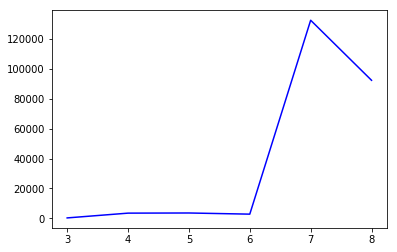

In [23]:
plt.plot(list(range(3,9)), total, 'b')
plt.axis()
plt.show()


In [ ]:
list(range(3,9))

In [ ]:
res = [289.8, 803.4, 5632.4, 3704.6, 22579.6, 166241.4]